# Maximum Mean Discrepancy drift detector on CIFAR-10

### Method

The [Maximum Mean Discrepancy (MMD)](http://jmlr.csail.mit.edu/papers/v13/gretton12a.html) detector is a kernel-based method for multivariate 2 sample testing. The MMD is a distance-based measure between 2 distributions *p* and *q* based on the mean embeddings $\mu_{p}$ and $\mu_{q}$ in a reproducing kernel Hilbert space $F$:

\begin{align}
MMD(F, p, q) & = || \mu_{p} - \mu_{q} ||^2_{F} \\
\end{align}

We can compute unbiased estimates of $MMD^2$ from the samples of the 2 distributions after applying the kernel trick. We use by default a [radial basis function kernel](https://en.wikipedia.org/wiki/Radial_basis_function_kernel), but users are free to pass their own kernel of preference to the detector. We obtain a $p$-value via a [permutation test](https://en.wikipedia.org/wiki/Resampling_(statistics)) on the values of $MMD^2$. This method is also described in [Failing Loudly: An Empirical Study of Methods for Detecting Dataset Shift](https://arxiv.org/abs/1810.11953).

### Dataset

[CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) consists of 60,000 32 by 32 RGB images equally distributed over 10 classes. We evaluate the drift detector on the CIFAR-10-C dataset ([Hendrycks & Dietterich, 2019](https://arxiv.org/abs/1903.12261)). The instances in
CIFAR-10-C have been corrupted and perturbed by various types of noise, blur, brightness etc. at different levels of severity, leading to a gradual decline in the classification model performance. We also check for drift against the original test set with class imbalances. 

In [1]:
import matplotlib.pyplot as plt
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Dense, Flatten, InputLayer, Reshape

from alibi_detect.cd import MMDDrift
from alibi_detect.cd.preprocess import UAE, HiddenOutput
from alibi_detect.models.resnet import scale_by_instance
from alibi_detect.utils.fetching import fetch_tf_model
from alibi_detect.utils.kernels import gaussian_kernel
from alibi_detect.utils.prediction import predict_batch
from alibi_detect.utils.saving import save_detector, load_detector
from alibi_detect.datasets import fetch_cifar10c, corruption_types_cifar10c

### Load data

Original CIFAR-10 data:

In [2]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255
y_train = y_train.astype('int64').reshape(-1,)
y_test = y_test.astype('int64').reshape(-1,)

For CIFAR-10-C, we can select from the following corruption types at 5 severity levels:

In [3]:
corruptions = corruption_types_cifar10c()
print(corruptions)

['brightness', 'contrast', 'defocus_blur', 'elastic_transform', 'fog', 'frost', 'gaussian_blur', 'gaussian_noise', 'glass_blur', 'impulse_noise', 'jpeg_compression', 'motion_blur', 'pixelate', 'saturate', 'shot_noise', 'snow', 'spatter', 'speckle_noise', 'zoom_blur']


Let's pick a subset of the corruptions at corruption level 5. Each corruption type consists of perturbations on all of the original test set images.

In [12]:
corruption = ['brightness', 'contrast', 'defocus_blur', 'elastic_transform', 'fog', 'frost', 'gaussian_blur', 'gaussian_noise', 'glass_blur', 'impulse_noise']
X_corr, y_corr = fetch_cifar10c(corruption=corruption, severity=5, return_X_y=True)
X_corr = X_corr.astype('float32') / 255

We split the original test set in a reference dataset and a dataset which should not be rejected under the *H<sub>0</sub>* of the MMD test. We also split the corrupted data by corruption type:

In [13]:
np.random.seed(0)
n_test = X_test.shape[0]
idx = np.random.choice(n_test, size=n_test // 2, replace=False)
idx_h0 = np.delete(np.arange(n_test), idx, axis=0)
X_ref,y_ref = X_test[idx], y_test[idx]
X_h0, y_h0 = X_test[idx_h0], y_test[idx_h0]
print(X_ref.shape, X_h0.shape)

(5000, 32, 32, 3) (5000, 32, 32, 3)


In [14]:
# check that the classes are more or less balanced
classes, counts_ref = np.unique(y_ref, return_counts=True)
counts_h0 = np.unique(y_h0, return_counts=True)[1]
print('Class Ref H0')
for cl, cref, ch0 in zip(classes, counts_ref, counts_h0):
    assert cref + ch0 == n_test // 10
    print('{}     {} {}'.format(cl, cref, ch0))

Class Ref H0
0     472 528
1     510 490
2     498 502
3     492 508
4     501 499
5     495 505
6     493 507
7     501 499
8     516 484
9     522 478


In [15]:
X_c = []
n_corr = len(corruption)
for i in range(n_corr):
    X_c.append(X_corr[i * n_test:(i + 1) * n_test])

We can visualise the same instance for each corruption type:

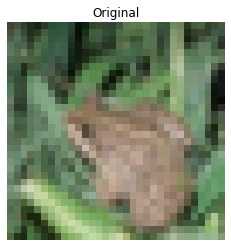

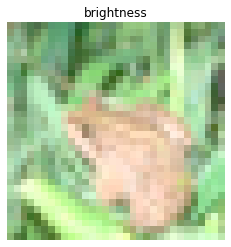

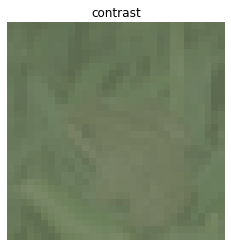

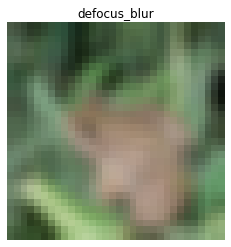

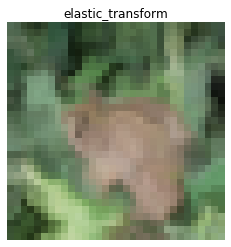

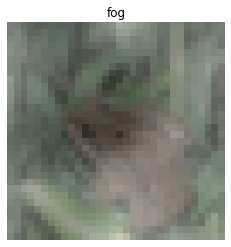

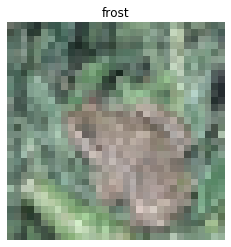

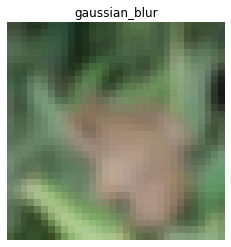

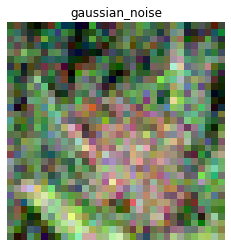

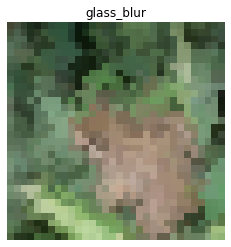

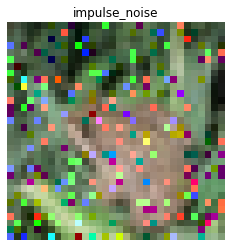

In [16]:
i = 4

n_test = X_test.shape[0]
plt.title('Original')
plt.axis('off')
plt.imshow(X_test[i])
plt.show()
for _ in range(len(corruption)):
    plt.title(corruption[_])
    plt.axis('off')
    plt.imshow(X_corr[n_test * _+ i])
    plt.show()

We can also verify that the performance of a classification model on CIFAR-10 drops significantly on this perturbed dataset:

In [17]:
dataset = 'cifar10'
model = 'resnet32'
clf = fetch_tf_model(dataset, model)
acc = clf.evaluate(scale_by_instance(X_test), y_test, batch_size=128, verbose=0)[1]
print('Test set accuracy:')
print('Original {:.4f}'.format(acc))
clf_accuracy = {'original': acc}
for _ in range(len(corruption)):
    acc = clf.evaluate(scale_by_instance(X_c[_]), y_test, batch_size=128, verbose=0)[1]
    clf_accuracy[corruption[_]] = acc
    print('{} {:.4f}'.format(corruption[_], acc))

Test set accuracy:
Original 0.9278
brightness 0.8913
contrast 0.7900
defocus_blur 0.5923
elastic_transform 0.6915
fog 0.7534
frost 0.6249
gaussian_blur 0.3993
gaussian_noise 0.2208
glass_blur 0.3957
impulse_noise 0.1926


Given the drop in performance, it is important that we detect the harmful data drift!

### Detect drift

We are trying to detect data drift on high-dimensional (*32x32x3*) data using a multivariate MMD permutation test. It therefore makes sense to apply dimensionality reduction first. Some dimensionality reduction methods also used in [Failing Loudly: An Empirical Study of Methods for Detecting Dataset Shift](https://arxiv.org/pdf/1810.11953.pdf) are readily available: **UAE** (Untrained AutoEncoder), **BBSDs** (black-box shift detection using the classifier's softmax outputs) and **PCA**. 

#### Untrained AutoEncoder

First we try UAE:

In [18]:
tf.random.set_seed(0)

# define encoder
encoding_dim = 32
encoder_net = tf.keras.Sequential(
  [
      InputLayer(input_shape=(32, 32, 3)),
      Conv2D(64, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2D(128, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2D(512, 4, strides=2, padding='same', activation=tf.nn.relu),
      Flatten(),
      Dense(encoding_dim,)
  ]
)
uae = UAE(encoder_net=encoder_net)
preprocess_kwargs = {'model': uae, 'batch_size': 128}

# initialise drift detector
cd_mmd = MMDDrift(
    p_val=.05,          # p-value for permutation test 
    X_ref=X_ref,        # reference data to test against
    preprocess_kwargs=preprocess_kwargs,
    kernel=gaussian_kernel,  # use the default Gaussian kernel in MMD
    kernel_kwargs={'sigma': np.array([1.])},
    chunk_size=1000,
    n_permutations=5    # nb of permutations in the test, set to 5 for runtime
)                       # purposes; should be much higher for a real test

# # we can also save/load an initialised detector
# filepath = 'my_path'  # change to directory where detector is saved
# save_detector(cd, filepath)
# cd = load_detector(filepath, **{'preprocess_kwargs': preprocess_kwargs})

The optional `chunk_size` variable will be used to compute the maximum mean discrepancy distance between the 2 samples in chunks using [dask](https://dask.org/) to avoid potential out-of-memory errors. In terms of speed, the optimal `chunk_size` is application and hardware dependent, so it is often worth to test a few different values, including *None*. *None* means that the computation is done in-memory in NumPy.

Let's check whether the detector thinks drift occurred within the original test set:

In [20]:
preds_h0 = cd_mmd.predict(X_h0, return_p_val=True)
labels = ['No!', 'Yes!']
print('Drift? {}'.format(labels[preds_h0['data']['is_drift']]))

Drift? No!


As expected, no drift occurred. The p-value of the permutation test is above the $0.05$ threshold:

In [21]:
print(preds_h0['data']['p_val'])

0.8


In [44]:
dataset = 'cifar10'
model = 'resnet32'
new_clf = fetch_tf_model(dataset, model)
acc = new_clf.evaluate(scale_by_instance(X_test), y_test, batch_size=128, verbose=0)[1]

drift_clf = fetch_tf_model(dataset, model)
acc = drift_clf.evaluate(scale_by_instance(X_test), y_test, batch_size=128, verbose=0)[1]

##### continous loop for detecting drift using various methods (MMD, KS)
import random
import time
current_milli_time = lambda: int(round(time.time() * 1000))
import copy
counter_mmd = 0
counter_ks = 0
orig_set_size = 1000
# corrupted_set_size = 1000
class_size = 10
result = {"method": "MMD", "model_acc": 100, "corrupted":0, "exec":0,"drift":2}
result = {"method": "MMD", "model_acc": 100,"model_acc_periodic": 100,"model_acc_drift": 100, "corrupted":0, "exec":0,"drift":2, "epoch":0}
retrained_mmd = 0
results = []
whole_began = current_milli_time() 
for k in range(0,20):
    result["epoch"] = k
    
    possible_sizes = [50, 100, 200, 250,500, 1000]
#     print(random.choice(possible_sizes))
    corrupted_set_size = random.choice(possible_sizes)
    print(f"Chosen: {corrupted_set_size}")
    
    result["corrupted"] = corrupted_set_size/orig_set_size
    print(f"so far iter : {i} , time {(current_milli_time() - whole_began)/1000}")
    for i in range(0,1):

        ## select randomly from orig
        idx = np.random.randint(10000, size=orig_set_size-corrupted_set_size)
#         acc = clf.evaluate(scale_by_instance(X_test[idx]), y_test[idx], batch_size=128, verbose=0)[1]
        temp = X_test[idx]
        temp_y = y_test[idx]
#         print('Test set accuracy:')
#         print('Original {:.4f}'.format(acc))
#         clf_accuracy_loop = {'original': acc}
        for x, c in zip(X_c, corruption):
            idx = np.random.randint(10000, size=int(corrupted_set_size/class_size))
    #         print("idx",idx)
#             preds = cd_mmd.predict(x[idx], return_p_val=True)
#             acc = clf.evaluate(scale_by_instance(x[idx]), y_test[idx], batch_size=128, verbose=0)[1]
#             print('Drift? {}'.format(labels[preds['data']['is_drift']]))
#             print(f'Corruption type: {c}')

            temp = np.concatenate((temp, x[idx]), axis=0)
            temp_y = np.concatenate((temp_y, y_test[idx]), axis=0)

        print(len(temp))
       
        acc = clf.evaluate(scale_by_instance(temp), temp_y, batch_size=128, verbose=0)[1]
#         accuracy_by_time.append(acc)
        print(f"*** Orig Acc for all : {acc}")
        acc2 = new_clf.evaluate(scale_by_instance(temp), temp_y, batch_size=128, verbose=0)[1]
        print(f"*** Orig Acc for new_clf : {acc2}")
        
        acc3 = drift_clf.evaluate(scale_by_instance(temp), temp_y, batch_size=128, verbose=0)[1]
        print(f"*** Orig Acc for drift_clf : {acc3}")
        print(f"")
        result["model_acc"] = acc
        result["model_acc_periodic"] = acc2
        result["model_acc_drift"]= acc3
        
        print("Retraining periodic")
        retrain_begin = current_milli_time()
        new_clf.fit(scale_by_instance(temp), temp_y, batch_size=128, epochs = 5)
        print(f"Retrained took: { current_milli_time() - retrain_begin}")



        begin_time = current_milli_time()
        preds_mmd = cd_mmd.predict(temp, return_p_val=True)
        end_time = current_milli_time()
#         exec_times["MMD"].append(end_time - begin_time)
        result["exec"] = end_time - begin_time

#         begin_time = current_milli_time()
#         preds_ks = cd.predict(temp, return_p_val=True)
#         end_time = current_milli_time()
#         exec_times["KS"].append(end_time - begin_time)


        if preds_mmd['data']['is_drift']:
#             drifter_acc["MMD"] = drifter_acc["MMD"] + 1
            result["drift"] = 1
            retrained_mmd = retrained_mmd+ 1
            print("MMD drift")
            print("Retraining drifter")
            retrain_mmd_begin = current_milli_time()
            drift_clf.fit(scale_by_instance(temp), temp_y, batch_size=128, epochs = 5)
            print(f"Retrained MMD took: { current_milli_time() - retrain_mmd_begin}")
        else:
            result["drift"] = 0
        print(f"** results: {result}")
        results.append(copy.copy(result))
#         if preds_ks['data']['is_drift']:
#             drifter_acc["KS"] = drifter_acc["KS"] + 1 
#             print("KS drift")
        print(f" Iter : {i}")
    print(f"******** for {corrupted_set_size}")
# #     print(f"**************MMD: {drifter_acc['MMD']}")
#     #     print(f"MMD: {drifter_acc['MMD']}")
#     print(f"**************exec MMD: {exec_times['MMD']}")
#     print(f"*** Acc for all : {acc}")
    #     print(f"exec MMD: {exec_times['MMD']}")

Chosen: 1000
so far iter : 0 , time 0.001
1000
*** Orig Acc for all : 0.5509999990463257
*** Orig Acc for new_clf : 0.5509999990463257
*** Orig Acc for drift_clf : 0.5509999990463257

Retraining periodic
Epoch 1/5
8/8 [==============================] - 11s 1s/step - loss: 1.9709 - sparse_categorical_accuracy: 0.6230
Epoch 2/5
8/8 [==============================] - 9s 1s/step - loss: 0.9315 - sparse_categorical_accuracy: 0.7980
Epoch 3/5
8/8 [==============================] - 10s 1s/step - loss: 0.4320 - sparse_categorical_accuracy: 0.9110
Epoch 4/5
8/8 [==============================] - 9s 1s/step - loss: 0.2653 - sparse_categorical_accuracy: 0.9650
Epoch 5/5
8/8 [==============================] - 9s 1s/step - loss: 0.2071 - sparse_categorical_accuracy: 0.9840
Retrained took: 57027
MMD drift
Retraining drifter
Epoch 1/5
8/8 [==============================] - 9s 1s/step - loss: 1.9709 - sparse_categorical_accuracy: 0.6230
Epoch 2/5
8/8 [==============================] - 9s 1s/step - los

8/8 [==============================] - 11s 1s/step - loss: 0.1960 - sparse_categorical_accuracy: 0.9810
Epoch 5/5
8/8 [==============================] - 9s 1s/step - loss: 0.1633 - sparse_categorical_accuracy: 0.9940
Retrained took: 58113
** results: {'method': 'MMD', 'model_acc': 0.8519999980926514, 'model_acc_periodic': 0.859000027179718, 'model_acc_drift': 0.8479999899864197, 'corrupted': 0.25, 'exec': 23112, 'drift': 0, 'epoch': 5}
 Iter : 0
******** for 250
Chosen: 50
so far iter : 0 , time 775.475
1000
*** Orig Acc for all : 0.9070000052452087
*** Orig Acc for new_clf : 0.8709999918937683
*** Orig Acc for drift_clf : 0.878000020980835

Retraining periodic
Epoch 1/5
8/8 [==============================] - 11s 1s/step - loss: 0.4724 - sparse_categorical_accuracy: 0.9070
Epoch 2/5
8/8 [==============================] - 12s 2s/step - loss: 0.3140 - sparse_categorical_accuracy: 0.9470
Epoch 3/5
8/8 [==============================] - 10s 1s/step - loss: 0.2198 - sparse_categorical_accur

8/8 [==============================] - 11s 1s/step - loss: 0.1718 - sparse_categorical_accuracy: 0.9930
Retrained took: 57631
** results: {'method': 'MMD', 'model_acc': 0.8169999718666077, 'model_acc_periodic': 0.8629999756813049, 'model_acc_drift': 0.843999981880188, 'corrupted': 0.25, 'exec': 24189, 'drift': 0, 'epoch': 11}
 Iter : 0
******** for 250
Chosen: 200
so far iter : 0 , time 1484.18
1000
*** Orig Acc for all : 0.8410000205039978
*** Orig Acc for new_clf : 0.902999997138977
*** Orig Acc for drift_clf : 0.8550000190734863

Retraining periodic
Epoch 1/5
8/8 [==============================] - 11s 1s/step - loss: 0.3946 - sparse_categorical_accuracy: 0.9160
Epoch 2/5
8/8 [==============================] - 10s 1s/step - loss: 0.2811 - sparse_categorical_accuracy: 0.9540
Epoch 3/5
8/8 [==============================] - 12s 1s/step - loss: 0.2169 - sparse_categorical_accuracy: 0.9830
Epoch 4/5
8/8 [==============================] - 12s 2s/step - loss: 0.2017 - sparse_categorical_ac

1000
*** Orig Acc for all : 0.7620000243186951
*** Orig Acc for new_clf : 0.875
*** Orig Acc for drift_clf : 0.8220000267028809

Retraining periodic
Epoch 1/5
8/8 [==============================] - 9s 1s/step - loss: 0.5220 - sparse_categorical_accuracy: 0.8750
Epoch 2/5
8/8 [==============================] - 9s 1s/step - loss: 0.3289 - sparse_categorical_accuracy: 0.9280
Epoch 3/5
8/8 [==============================] - 9s 1s/step - loss: 0.2379 - sparse_categorical_accuracy: 0.9660
Epoch 4/5
8/8 [==============================] - 9s 1s/step - loss: 0.1815 - sparse_categorical_accuracy: 0.9910
Epoch 5/5
8/8 [==============================] - 9s 1s/step - loss: 0.1637 - sparse_categorical_accuracy: 0.9940
Retrained took: 50646
MMD drift
Retraining drifter
Epoch 1/5
8/8 [==============================] - 9s 1s/step - loss: 0.6084 - sparse_categorical_accuracy: 0.8540
Epoch 2/5
8/8 [==============================] - 9s 1s/step - loss: 0.3844 - sparse_categorical_accuracy: 0.9180
Epoch 3/5

In [46]:
retrained_mmd

12

Let's now check the predictions on the perturbed data:

In [45]:
import csv
csv_columns = ["method", "model_acc", "model_acc_periodic","model_acc_drift","corrupted", "exec","drift","epoch"]
csv_file = "retraining-MMD-updated.csv"



with open(csv_file, 'w') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=csv_columns)
    writer.writeheader()
    for data in results:
        writer.writerow(data)

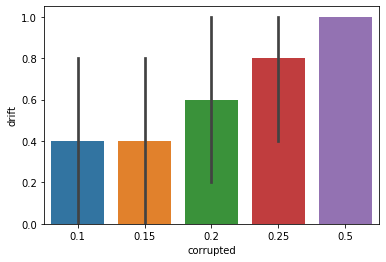

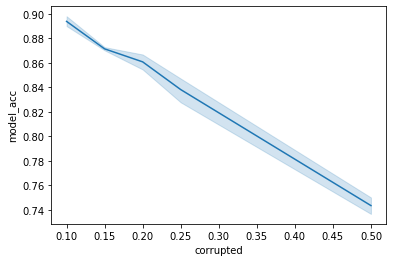

In [32]:
import seaborn as sns
import pandas as pd

df = pd.read_csv('MMD-results-updated.csv')
fig,ax = plt.subplots()
a= sns.barplot(ax=ax,
    data=df, 
    x="corrupted", y="drift",ci=95
)
fig2,ax2 = plt.subplots()
ba= sns.lineplot(ax=ax2,
    data=df, 
    x="corrupted", y="model_acc"
)

In [13]:
for x, c in zip(X_c, corruption):
    preds = cd.predict(x, return_p_val=True)
    print(f'Corruption type: {c}')
    print('Drift? {}'.format(labels[preds['data']['is_drift']]))
    print('Feature-wise p-values:')
    print(preds['data']['p_val'])
    print('')

Corruption type: gaussian_noise
Drift? Yes!
Feature-wise p-values:
0.0

Corruption type: motion_blur
Drift? Yes!
Feature-wise p-values:
0.0

Corruption type: brightness
Drift? Yes!
Feature-wise p-values:
0.0

Corruption type: pixelate
Drift? Yes!
Feature-wise p-values:
0.0



#### BBSDs

For **BBSDs**, we use the classifier's softmax outputs for black-box shift detection. This method is based on [Detecting and Correcting for Label Shift with Black Box Predictors](https://arxiv.org/abs/1802.03916). The ResNet classifier is trained on data standardised by instance so we need to rescale the data.

In [14]:
X_train = scale_by_instance(X_train)
X_test = scale_by_instance(X_test)
for i in range(n_corr):
    X_c[i] = scale_by_instance(X_c[i])
X_ref = scale_by_instance(X_ref)
X_h0 = scale_by_instance(X_h0)

Initialisation of the drift detector. Here we use the output of the softmax layer to detect the drift, but other hidden layers can be extracted as well by setting *'layer'* to the index of the desired hidden layer in the model:

In [15]:
# use output softmax layer
preprocess_kwargs = {'model': HiddenOutput(model=clf, layer=-1), 'batch_size': 128}

cd = MMDDrift(
    p_val=.05,
    X_ref=X_ref,
    preprocess_kwargs=preprocess_kwargs,
    kernel_kwargs={'sigma': np.array([1.])},
    chunk_size=1000,
    n_permutations=5
)

There is no drift on the original held out test set:

In [16]:
preds_h0 = cd.predict(X_h0)
print('Drift? {}'.format(labels[preds_h0['data']['is_drift']]))
print(preds_h0['data']['p_val'])

Drift? No!
0.4


We compare this with the perturbed data:

In [17]:
for x, c in zip(X_c, corruption):
    preds = cd.predict(x)
    print(f'Corruption type: {c}')
    print('Drift? {}'.format(labels[preds['data']['is_drift']]))
    print('Feature-wise p-values:')
    print(preds['data']['p_val'])
    print('')

Corruption type: gaussian_noise
Drift? Yes!
Feature-wise p-values:
0.0

Corruption type: motion_blur
Drift? Yes!
Feature-wise p-values:
0.0

Corruption type: brightness
Drift? Yes!
Feature-wise p-values:
0.0

Corruption type: pixelate
Drift? Yes!
Feature-wise p-values:
0.0



### Kernel bandwidth

So far we have defined a specific bandwidth `sigma` for the Gaussian kernel. We can however also sum over a number of different kernel bandwidths or infer `sigma` from *X_ref* and *X* using the following heuristic: compute the pairwise distances between each of the instances in *X_ref* and *X*, and set `sigma` to the median distance.

Let's first try a range of bandwidths:

In [18]:
cd = MMDDrift(
    p_val=.05,
    X_ref=X_ref,
    preprocess_kwargs=preprocess_kwargs,
    kernel_kwargs={'sigma': np.array([.5, 1., 5.])},
    chunk_size=1000,
    n_permutations=5
)

In [19]:
preds_h0 = cd.predict(X_h0)
print('Original test set sample')
print('Drift? {}'.format(labels[preds_h0['data']['is_drift']]))
print(preds_h0['data']['p_val'])
print('')

for x, c in zip(X_c, corruption):
    preds = cd.predict(x)
    print(f'Corruption type: {c}')
    print('Drift? {}'.format(labels[preds['data']['is_drift']]))
    print('Feature-wise p-values:')
    print(preds['data']['p_val'])
    print('')

Original test set sample
Drift? No!
0.2

Corruption type: gaussian_noise
Drift? Yes!
Feature-wise p-values:
0.0

Corruption type: motion_blur
Drift? Yes!
Feature-wise p-values:
0.0

Corruption type: brightness
Drift? Yes!
Feature-wise p-values:
0.0

Corruption type: pixelate
Drift? Yes!
Feature-wise p-values:
0.0



A bandwidth can also be inferred from *X_ref* and *X* using the heuristic:

In [20]:
cd = MMDDrift(
    p_val=.05,
    X_ref=X_ref,
    preprocess_kwargs=preprocess_kwargs,
    chunk_size=1000,
    n_permutations=5
)

In [21]:
preds_h0 = cd.predict(X_h0)
print('Drift? {}'.format(labels[preds_h0['data']['is_drift']]))
print(preds_h0['data']['p_val'])

Drift? No!
0.2


In [22]:
print('Inferred bandwidth: {:.4f}'.format(cd.permutation_test.keywords['sigma'].item()))

Inferred bandwidth: 1.4132


### Label drift

We can also check what happens when we introduce class imbalances between the reference data *X_ref* and the tested data *X_imb*. The reference data will use $75$% of the instances of the first 5 classes and only $25$% of the last 5. The data used for drift testing then uses respectively $25$% and $75$% of the test instances for the first and last 5 classes.

In [23]:
np.random.seed(0)
# get index for each class in the test set
num_classes = len(np.unique(y_test))
idx_by_class = [np.where(y_test == c)[0] for c in range(num_classes)]
# sample imbalanced data for different classes for X_ref and X_imb
perc_ref = .75
perc_ref_by_class = [perc_ref if c < 5 else 1 - perc_ref for c in range(num_classes)]
n_by_class = n_test // num_classes
X_ref = []
X_imb, y_imb = [], []
for _ in range(num_classes):
    idx_class_ref = np.random.choice(n_by_class, size=int(perc_ref_by_class[_] * n_by_class), replace=False)
    idx_ref = idx_by_class[_][idx_class_ref]
    idx_class_imb = np.delete(np.arange(n_by_class), idx_class_ref, axis=0)
    idx_imb = idx_by_class[_][idx_class_imb]
    assert idx_ref != idx_imb
    X_ref.append(X_test[idx_ref])
    X_imb.append(X_test[idx_imb])
    y_imb.append(y_test[idx_imb])
X_ref = np.concatenate(X_ref)
X_imb = np.concatenate(X_imb)
y_imb = np.concatenate(y_imb)
print(X_ref.shape, X_imb.shape, y_imb.shape)

(5000, 32, 32, 3) (5000, 32, 32, 3) (5000,)


Update reference dataset for the detector and make predictions:

In [24]:
cd.X_ref = cd.preprocess_fn(X_ref)

In [25]:
preds_imb = cd.predict(X_imb)
print('Drift? {}'.format(labels[preds_imb['data']['is_drift']]))
print(preds_imb['data']['p_val'])

Drift? Yes!
0.0
